Train on 383 samples, validate on 256 samples
Epoch 1/150
383/383 [==============================] - 2s - loss: 0.2670 - val_loss: 0.0130
Epoch 2/150
383/383 [==============================] - 0s - loss: 0.2387 - val_loss: 0.0229
Epoch 3/150
383/383 [==============================] - 0s - loss: 0.2150 - val_loss: 0.0461
Epoch 4/150
383/383 [==============================] - 0s - loss: 0.1968 - val_loss: 0.0663
Epoch 5/150
383/383 [==============================] - 0s - loss: 0.1849 - val_loss: 0.0826
Epoch 6/150
383/383 [==============================] - 0s - loss: 0.1770 - val_loss: 0.0944
Epoch 7/150
383/383 [==============================] - 0s - loss: 0.1718 - val_loss: 0.1018
Epoch 8/150
383/383 [==============================] - 0s - loss: 0.1676 - val_loss: 0.1065
Epoch 9/150
383/383 [==============================] - 0s - loss: 0.1639 - val_loss: 0.1095
Epoch 10/150
383/383 [==============================] - 0s - loss: 0.1605 - val_loss: 0.1117
Epoch 11/150
383/383 [===========

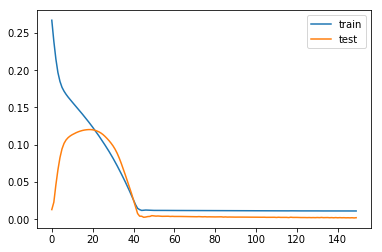

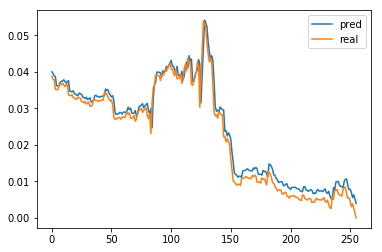

test 11.974042155716464


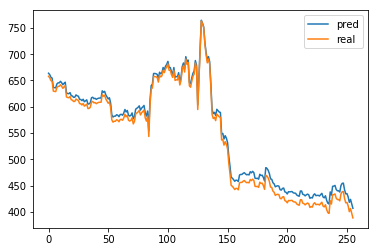

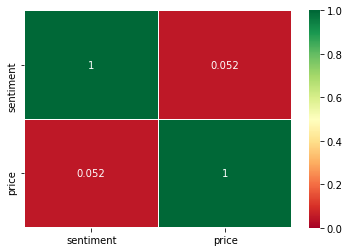

Train on 448 samples, validate on 192 samples
Epoch 1/150
448/448 [==============================] - 3s - loss: 0.2238 - val_loss: 0.0133
Epoch 2/150
448/448 [==============================] - 0s - loss: 0.2007 - val_loss: 0.0219
Epoch 3/150
448/448 [==============================] - 0s - loss: 0.1841 - val_loss: 0.0372
Epoch 4/150
448/448 [==============================] - 0s - loss: 0.1736 - val_loss: 0.0494
Epoch 5/150
448/448 [==============================] - 0s - loss: 0.1657 - val_loss: 0.0588
Epoch 6/150
448/448 [==============================] - 0s - loss: 0.1598 - val_loss: 0.0656
Epoch 7/150
448/448 [==============================] - 0s - loss: 0.1554 - val_loss: 0.0702
Epoch 8/150
448/448 [==============================] - 0s - loss: 0.1518 - val_loss: 0.0731
Epoch 9/150
448/448 [==============================] - 0s - loss: 0.1487 - val_loss: 0.0749
Epoch 10/150
448/448 [==============================] - 0s - loss: 0.1458 - val_loss: 0.0757
Epoch 11/150
448/448 [===========

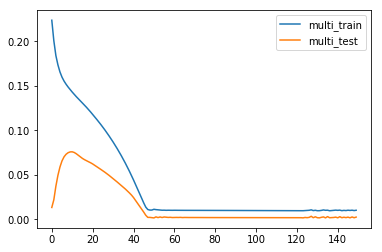

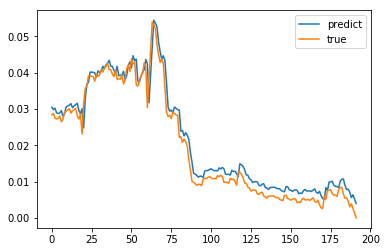

Test RMSE: 20.813


In [23]:
# -*- coding: utf-8 -*-
"""
@author: JulienWuthrich
"""
import os
from numpy import concatenate
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot
import seaborn as sns
from math import sqrt

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

py.init_notebook_mode(True)


class TrainLSTM(object):
    """Module to build, and train an LSTM"""

    def __init__(self, filename):
        """Initialize a `TrainLSTM` object.

            Arg:
                filename (str): path of the file
        """
        self.filename = filename
        self.split = 0.6

    def read_file(self):
        """Read the file.

            Return:
                data (pd.DataFrame): data
        """
        return pd.read_csv(self.filename)

    @staticmethod
    def show_price_evolution(df):
        """."""
        btc_trace = go.Scatter(x=df['stamp'], y=df["price"], name="Price")
        py.iplot([btc_trace])

    @staticmethod
    def replace_0(df):
        """."""
        df["price"].replace(0, np.nan, inplace=True)
        df["price"].fillna(method="ffill", inplace=True)
        
        return df

    @staticmethod
    def scale(df):
        """."""
        values = df["price"].values.reshape(-1, 1)
        values = values.astype("float32")
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        return scaler.fit_transform(values), scaler
    
    def split_data(self, scaled):
        """."""
        train_size = int(len(scaled) * self.split)
        test_size = len(scaled) - train_size
        train, test = scaled[0: train_size, :], scaled[train_size: len(scaled), :]
        split = train_size
        
        return train, test, train_size

    def create_dataset(self, dataset, look_back, sentiment):
        """."""
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            res = dataset[i: (i + look_back), 0]
            np.append(res, sentiment[i])
            dataX.append(res)
            dataY.append(dataset[i + look_back, 0])
        
        return np.array(dataX), np.array(dataY)

    def reshape_X(self, df):
        """."""
        return np.reshape(df, (df.shape[0], 1, df.shape[1]))

    def build_model(self, trainX):
        """."""
        model = Sequential()
        model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
        model.add(Dense(1))
        model.compile(loss="mae", optimizer="adam")
        
        return model

    def show_val_loss(self, history):
        """."""
        pyplot.plot(history.history["loss"], label="train")
        pyplot.plot(history.history["val_loss"], label="test")
        pyplot.legend()
        pyplot.show()

    def show_pred_real(self, real, pred):
        """."""
        pyplot.plot(pred, label="pred")
        pyplot.plot(real, label="real")
        pyplot.legend()
        pyplot.show()
    
    def inverse_scale(self, scaler, val):
        """."""
        return scaler.inverse_transform(val.reshape(-1, 1))

    def reshape_Y(self, df):
        """."""
        return df.reshape(len(df))

    def show_by_date(self, predDates, real, pred):
        """."""
        actual = go.Scatter(x=predDates, y=real, name="Actual")
        pred = go.Scatter(x=predDates, y=pred, name="Pred")
        py.iplot([pred, actual])

    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    def fit_transform(self):
        """."""
        df = self.read_file()
        df.dropna(axis=1, how="all")
        df["stamp"] = pd.to_datetime(df["stamp"].apply(str), format="%Y%m%d")
        self.show_price_evolution(df)
        df = self.replace_0(df)
        self.show_price_evolution(df)
        scaled, scaler = self.scale(df)
        sentiment = df["sentiment"].values.reshape(-1, 1).astype("float32")
        train, test, train_size = self.split_data(scaled)
        trainX, trainY = self.create_dataset(train, 1, sentiment[0: train_size])
        testX, testY = self.create_dataset(test, 1, sentiment[train_size:])
        trainX = self.reshape_X(trainX)
        testX = self.reshape_X(testX)
        model = self.build_model(trainX)
        history = model.fit(trainX, trainY, epochs=150, batch_size = 64, validation_data=(testX, testY), verbose=1, shuffle=False)
        self.show_val_loss(history)
        pred = model.predict(testX)
        self.show_pred_real(testY, pred)
        pred_inv = self.inverse_scale(scaler, pred)
        real_inv = self.inverse_scale(scaler, testX)
        rmse = sqrt(mean_squared_error(real_inv, pred_inv))
        print("test", rmse)
        self.show_pred_real(real_inv, pred_inv)
        predDates = df.tail(len(testX))["stamp"]
        real_inv_resh = self.reshape_Y(real_inv)
        pred_inv_resh = self.reshape_Y(pred_inv)
        self.show_by_date(predDates, real_inv_resh, pred_inv_resh)
        sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", linewidths=0.1, vmin=0)
        pyplot.show()

        values = df[["price"]].values
        values = values.astype("float32")
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        reframed = self.series_to_supervised(scaled, 1, 1)

        values = reframed.values
        n_train_hours = int(len(values) * 0.7)
        train = values[:n_train_hours, :]
        test = values[n_train_hours:, :]
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        
        multi_model = Sequential()
        multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
        multi_model.add(Dense(1))
        multi_model.compile(loss='mae', optimizer='adam')
        multi_history = multi_model.fit(train_X, train_y, epochs=150, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

        pyplot.plot(multi_history.history['loss'], label='multi_train')
        pyplot.plot(multi_history.history['val_loss'], label='multi_test')
        pyplot.legend()
        pyplot.show()

        yhat = multi_model.predict(test_X)
        pyplot.plot(yhat, label='predict')
        pyplot.plot(test_y, label='true')
        pyplot.legend()
        pyplot.show()
        
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
        inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]

        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)

        actual_chart = go.Scatter(x=predDates, y=inv_y, name= 'Actual Price')
        multi_predict_chart = go.Scatter(x=predDates, y=inv_yhat, name= 'Multi Predict Price')
        predict_chart = go.Scatter(x=predDates, y=pred_inv_resh, name= 'Predict Price')
        py.iplot([predict_chart, multi_predict_chart, actual_chart])

if __name__ == '__main__':
    path = "/Users/az02210/Documents/Python/BitCoinPrediction/data/converged/merged.csv"
    TrainLSTM(path).fit_transform()